# "Galfitting" with lenstronomy
An example of using **lenstronomy** without imposing a lensing deflector is the inference of galaxy structural parameters through the fitting of a parameterized surface brightness model (or many thereof).

We want to demonstrate the flexibility of **lenstronomy**. Matching the structural properties of lensing and source galaxy is an integral part of lens modelling. **lenstronomy** may provide an alternative in python to other software that are more specific to this task.
The 'lens_light_model' effectively describes undistorted surface brightness profiles in lenstronomy.

**lenstronomy** supports a wide range of light profiles. You can find the current list here: https://github.com/sibirrer/lenstronomy/blob/master/lenstronomy/LightModel/light_model_base.py

A key difference to other ligth profile fitting codes is that **lenstronomy** solves the amplitude parameter of the different components with a linear minimizer on the fly. An arbitrary number of superposition of different profiles is supported, including shapelets and wavelets, to describe complex structure.

**lenstronomy** also supports multi-band, multi-exposure, and multi-object fitting. We refer to other notebooks about the handling of those tasks. In short, all the tasks that are supported when using lenstronomy in the 'lensing model' are also supported when turning lensing off - with the identical API.

<div class="alert alert-warning">

**Warning:** Small sources and very cuspy cores (such as Sersic profiels with high Sersic indexes) result in steep surface brightness variations below the pixel scale. The numerics used in this notebook only evaluates the surface brighness in the centre of each pixel and assigns the entire pixel this surface brightness value. Super-sampled evaluation of surface brightness profiles may be required. Lenstronomy supports this, both on a grid and adaptive in specific regions. We refer to the $\texttt{Numerics}$ module and a dedicated notebook on numerical aspects.

</div>

Additional features are available with the software [GaLight](https://github.com/dartoon/galight), which wrapps around lenstronomy.


In [1]:
# some standard python imports #
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import matplotlib as mpl

# for MNRAS
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable
import matplotlib.image as mpimg
import seaborn as sns
import coloripy as cp

# to change tex to Times New Roman in mpl
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['mathtext.it'] = 'serif:italic'
plt.rcParams['mathtext.bf'] = 'serif:bold'
plt.rcParams['mathtext.fontset'] = 'custom'


sns.set(style='ticks', context='paper', font='Times New Roman', font_scale=2.)
#sns.set_context('talk')
sns.set_style({"xtick.direction": "in","ytick.direction": "in", "axes.linewidth": 2.0,})
#sns.set_palette('Set2')

cmap = sns.cubehelix_palette(start=0.5, rot=-1.5, gamma=1, hue=1, light=-.6, dark=0.8, reverse=False, as_cmap=True)
cmap2 = sns.cubehelix_palette(start=0.5, rot=-1.5, gamma=1, hue=1, light=-.2, dark=1., reverse=False, as_cmap=True)

msh_cmap = cp.get_msh_cmap(num_bins=501, rescale='power', power=2.5)

In [3]:
import h5py
import os

def import_data(filter_name):
    data_file = os.path.join('/Volumes/T7/AGEL/15867/cutout/DESI-118.8480+34.7610' ,'image_DESI-118.8480+34.7610_{}_galaxy.h5'.format(filter_name))
    f = h5py.File(data_file, 'r')
    
    data_reduced = f['image_data'][()]
    background_rms = f['background_rms'][()]
    exposure_map = f['exposure_time'][()]
    ra_at_xy_0 = f['ra_at_xy_0'][()]
    dec_at_xy_0 = f['dec_at_xy_0'][()]
    transform_pix2angle = f['transform_pix2angle'][()]
    f.close()

    kwargs_data = {'image_data': data_reduced, 
                    'background_rms': background_rms,
                    'noise_map': None,
                    'exposure_time': exposure_map,
                    'ra_at_xy_0': ra_at_xy_0,
                    'dec_at_xy_0': dec_at_xy_0, 
                    'transform_pix2angle': transform_pix2angle
                    }

    # get data and PSF estimate from file
    psf_file = os.path.join('/Volumes/T7/AGEL/15867/cutout/DESI-118.8480+34.7610', 'psf_DESI-118.8480+34.7610_{}.h5'.format(filter_name))
    f = h5py.File(psf_file, 'r')
    kernel_point_source = f['kernel_point_source'][()]
    # psf_error_map = f['psf_error_map'][()]
    f.close()


    kwargs_psf = {'psf_type': "PIXEL", 
                   'kernel_point_source': kernel_point_source ,
                   'kernel_point_source_init': kernel_point_source ,
                #    'psf_error_map': psf_error_map,
                   }
    
    return kwargs_data, kwargs_psf

kwargs_data_f140w, kwargs_psf_f140w = import_data('F140W')

kwargs_data_f140w['ra_shift'], kwargs_data_f140w['dec_shift'] = 0.1905, 0.0022

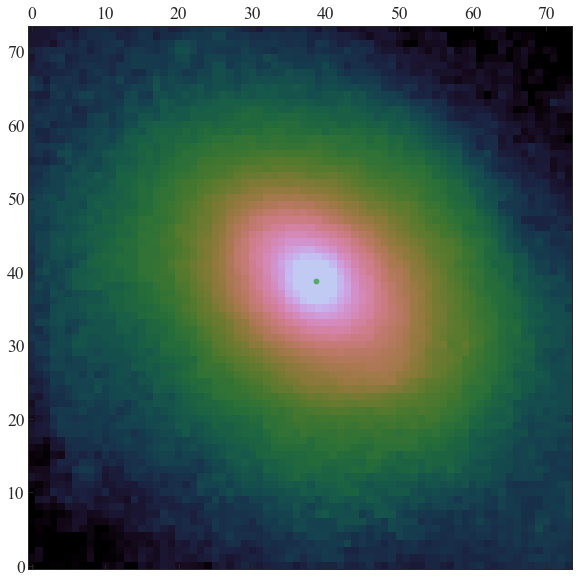

In [4]:
from lenstronomy.Data.coord_transforms import Coordinates

# read-in the coordiante system of the exposure
ra_at_xy_0 = kwargs_data_f140w['ra_at_xy_0']
dec_at_xy_0 = kwargs_data_f140w['dec_at_xy_0']
transform_pix2angle = kwargs_data_f140w['transform_pix2angle']
coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)

# read-in the reduced cutout image
data_cutout = kwargs_data_f140w['image_data']
numPix = len(data_cutout)

ax = plt.figure(figsize=(10, 10)).add_subplot(111)
ax.matshow(np.log10(data_cutout), origin='lower', cmap=cmap, vmin=-3, vmax=1.)
ax.autoscale(False)

lens_center_ra, lens_center_dec = 0.1905, 0.0022

lens_x, lens_y = coords.map_coord2pix(lens_center_ra, lens_center_dec)

ax.plot(lens_x, lens_y, 'og')    
#plt.colorbar()
plt.show()

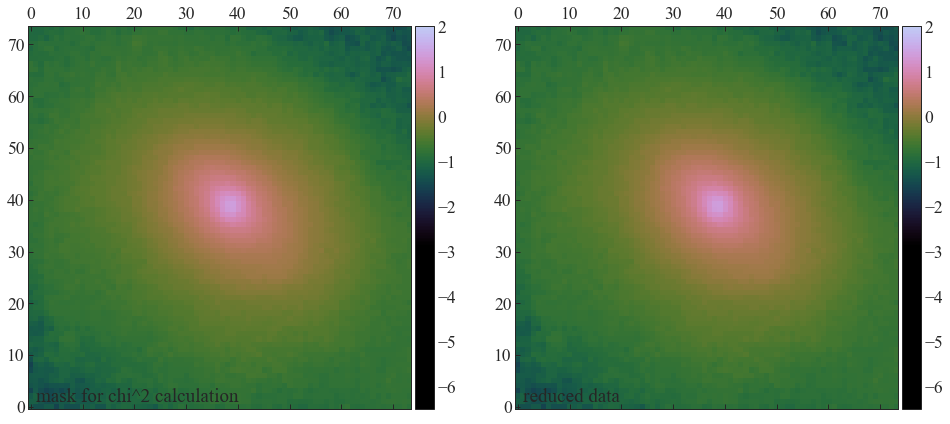

In [5]:
import lenstronomy.Util.util as util
from lenstronomy.Util.util import array2image
from lenstronomy.Util import mask_util
central_mask = True
central_mask_r = 0.3

r_mask_list = [
    [5], # f814w 
    [5], # f475x
    # [3.0]  # f160w
    ]

mask_list = []
index_mask_list = []

for i in range(len(r_mask_list[0])):
    mask_bands = []
    index_mask_bands = []

    for j, kwargs_data in enumerate([kwargs_data_f140w]):
        ra_at_xy_0 = kwargs_data['ra_at_xy_0'] - kwargs_data['ra_shift']
        dec_at_xy_0 = kwargs_data['dec_at_xy_0'] - kwargs_data['dec_shift']
        transform_pix2angle = kwargs_data['transform_pix2angle']
        coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
        num_pix = len(kwargs_data['image_data'])

        x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)
        
        r = r_mask_list[j][i]
        
        mask_outer = mask_util.mask_center_2d(lens_center_ra, lens_center_dec, r, util.image2array(x_coords), util.image2array(y_coords))
        index_mask = 1 - mask_util.mask_center_2d(lens_center_ra, lens_center_dec, r+0.3, util.image2array(x_coords), util.image2array(y_coords))

        mask = (1 - mask_outer)

        mask[mask >= 1] = 1
        mask[mask < 0] = 0
        
        mask_bands.append(array2image(mask))
        index_mask_bands.append(index_mask)
        
    mask_list.append(mask_bands)
    index_mask_list.append(index_mask_bands)

for j, kwargs_data in enumerate([kwargs_data_f140w]):
    image = kwargs_data['image_data']
    
    f, axes = plt.subplots(1, len(r_mask_list[0])+1, figsize=(16, 8), sharex=False, sharey=False)
    for i in range(len(r_mask_list[0])):
        ax = axes[i]
        
        mask = mask_list[0][j]
        
        im = ax.matshow(np.log10(image*mask), origin='lower', cmap=cmap, vmax=2, vmin=-6.5)
        ax.text(1, 1, 'mask for chi^2 calculation')
        ax.autoscale(False)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

        ax = axes[i+1]
        im = ax.matshow(np.log10(image), origin='lower', cmap=cmap, vmax=2, vmin=-6.5)
        ax.text(1, 1, 'reduced data')
        ax.autoscale(False)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

        plt.show()

/Users/hskobe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log10


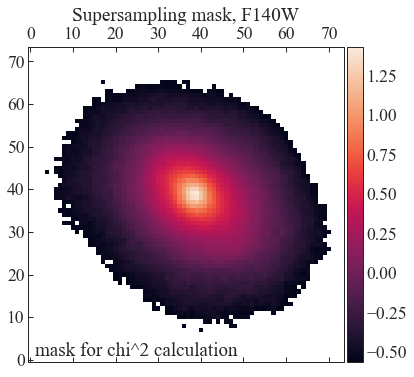

In [6]:
threshold = 10**(5/2.5) 
# pixels with flux > max_flux/threshold will not be supersampled
# here th threshold accepts pixels within 5 magnitude from the pixel with max_flux

supersampling_mask = []

for j, kwargs_data in enumerate([kwargs_data_f140w]):
    s_mask = np.ones_like(kwargs_data['image_data'])
    
    max_flux = np.max(kwargs_data['image_data'])
    s_mask[kwargs_data['image_data'] < max_flux/threshold] = 0
    
    supersampling_mask.append(s_mask)

filters = ['F140W']

for j, kwargs_data in enumerate([kwargs_data_f140w]):
    image = kwargs_data['image_data']
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)

    mask = supersampling_mask[j]*mask_list[0][j]
    im = ax.matshow(np.log10(image*mask), origin='lower')
    ax.text(1, 1, 'mask for chi^2 calculation')
    ax.autoscale(False)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ax.set_title("Supersampling mask, "+filters[j])
    plt.colorbar(im, cax=cax)

    plt.show()

In [7]:

deltaPix = coords.pixel_width
lens_bound = 0.2

lens_light_model_list = ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'HERNQUIST']

# here we super-sample the resolution of some of the pixels where the surface brightness profile has a high gradient 
supersampled_indexes = np.zeros((numPix, numPix), dtype=bool)
supersampled_indexes[37:41, 37:41] = True

kwargs_numerics = {'supersampling_factor': 4, 
                   'compute_mode': 'adaptive',
                  'supersampled_indexes': supersampled_indexes}

# kwargs_numerics = {'supersampling_factor': 2,
#                                 'supersampling_convolution': False, 
#                                 'supersampling_kernel_size': 11,
#                                 'flux_evaluate_indexes': None,
#                                 'point_source_supersampling_factor': 1,
#                                 'compute_mode': 'adaptive',  # 'adaptive'
#                                 'supersampled_indexes': np.array(supersampling_mask[i]*mask[i], dtype=bool),
#                                }

In [8]:
kwargs_model = {'lens_light_model_list': lens_light_model_list}
kwargs_constraints = {'joint_lens_light_with_lens_light': [[0, 1, ['center_x', 'center_y']],  [0, 1, ['e1', 'e2', 'n_sersic']],
                                                            [0, 2, ['center_x', 'center_y']]]} # , [0, 2, ['e1', 'e2', 'n_sersic']],
                                                            # [0, 3, ['center_x', 'center_y']], [1, 3, ['e1', 'e2', 'n_sersic']]]}
kwargs_likelihood = {'check_bounds': True}

image_band = [kwargs_data_f140w, kwargs_psf_f140w, kwargs_numerics]
multi_band_list = [image_band]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}

In [9]:

# lens light model choices
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []
joint_lens_light_with_lens_light = []
lens_light_index_with_centroid = 0

joint_lens_light_with_lens_light.append([lens_light_index_with_centroid, len(lens_light_model_list)-1, ['center_x', 'center_y']])
joint_lens_light_with_lens_light.append([lens_light_index_with_centroid, len(lens_light_model_list)-1, ['e1', 'e2', 'n_sersic']])


# first Sersic component
fixed_lens_light.append({})
# kwargs_lens_light_init.append(
#         {'amp': 12.785031634712599, 'R_sersic': 5.84374159325907, 
#             'n_sersic': 4, 'e1': -0.26839778822797533, 
#             'e2': 0.4251632692561582, 'center_x': lens_center_ra, 
#             'center_y': lens_center_dec}
#     )
# kwargs_lens_light_sigma.append({'center_x': deltaPix/10, 'center_y': deltaPix/10, 'R_sersic': 0.05,'n_sersic': 4, 'e1': 0.1, 'e2': 0.1})
# kwargs_lower_lens_light.append({'e1': -0.8, 'e2': -0.8, 'n_sersic': 4, 'R_sersic': 0.1, 'center_y': lens_center_dec-lens_bound, 'center_x': lens_center_ra-lens_bound})
# kwargs_upper_lens_light.append({'e1': 0.8, 'e2': 0.8, 'n_sersic': 8, 'R_sersic': 10, 'center_y': lens_center_dec+lens_bound, 'center_x': lens_center_ra+lens_bound})

kwargs_lens_light_init.append({'R_sersic': .1, 'n_sersic': 4, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0})
kwargs_lens_light_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.2, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.01, 'n_sersic': 0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 8, 'center_x': 10, 'center_y': 10})


# second Sersic component
fixed_lens_light.append({})
# kwargs_lens_light_init.append(
#         {'amp': 12.785031634712599, 'R_sersic': 5.84374159325907, 
#             'n_sersic': 4, 'e1': -0.26839778822797533, 
#             'e2': 0.4251632692561582, 'center_x': lens_center_ra, 
#             'center_y': lens_center_dec}
#     )
# kwargs_lens_light_sigma.append({'center_x': deltaPix/10, 'center_y': deltaPix/10, 'R_sersic': 0.05,'n_sersic': 4, 'e1': 0.1, 'e2': 0.1})
# kwargs_lower_lens_light.append({'e1': -0.8, 'e2': -0.8, 'n_sersic': 4, 'R_sersic': 0.1, 'center_y': lens_center_dec-lens_bound, 'center_x': lens_center_ra-lens_bound})
# kwargs_upper_lens_light.append({'e1': 0.8, 'e2': 0.8, 'n_sersic': 8, 'R_sersic': 10, 'center_y': lens_center_dec+lens_bound, 'center_x': lens_center_ra+lens_bound})

kwargs_lens_light_init.append({'R_sersic': .5, 'n_sersic': 4, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0})
kwargs_lens_light_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.2, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.01, 'n_sersic': 0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 8, 'center_x': 10, 'center_y': 10})

# Hernquist component
fixed_lens_light.append({})
kwargs_lens_light_init.append({'Rs': 0.7, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0})
kwargs_lens_light_sigma.append({'Rs': 0.3, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.5, 'center_y': 0.5})
kwargs_lower_lens_light.append({'Rs': 0.01, 'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'Rs': 10, 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10})


lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]

kwargs_params = {'lens_light_model': lens_light_params}


from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['PSO', {'sigma_scale': .05, 'n_particles': 200, 'n_iterations': 200}],
                        ['PSO', {'sigma_scale': .5, 'n_particles': 200, 'n_iterations': 200}],
                        ['PSO', {'sigma_scale': .05, 'n_particles': 200, 'n_iterations': 200}]]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()



Computing the PSO ...
10
PSO: Exception while calling your likelihood function:
  params: [0.14171786873857734, 4.018649469425549, -0.047138009059279035, -0.001305881835107091, 0.49109783197906826, 0.00595753244615575, 0.5197937857430716, 0.6762112444052256]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/hskobe/anaconda3/lib/python3.7/site-packages/lenstronomy/Sampling/Samplers/pso.py", line 446, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/hskobe/anaconda3/lib/python3.7/site-packages/lenstronomy/Sampling/likelihood.py", line 165, in logL
    return self.log_likelihood(kwargs_return, verbose=verbose)
  File "/Users/hskobe/anaconda3/lib/python3.7/site-packages/lenstronomy/Sampling/likelihood.py", line 180, in log_likelihood
    logL_image = self.image_likelihood.logL(**kwargs_return)
  File "/Users/hskobe/anaconda3/lib/python3.7/site-packages/lenstronomy/Sampling/Likelihoods/image_likelihood.py", line 55, in logL
    check_positive_flux=self._check_positive_flux)
  File "/Users/hskobe/anaconda3/lib/python3.7/site-packages/lenstronomy/ImSim/MultiBand/multi_linear.py", line 100, in likelihood_data_given_model
    check_positive_flux=check_positive_flux)
  File "/Users/hskobe/anaconda3/lib/python3.7/site-packag

KeyboardInterrupt: 

In [ ]:
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import chain_plot

modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")

for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)

f, axes = plt.subplots(1, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0])
modelPlot.model_plot(ax=axes[1])
modelPlot.normalized_residual_plot(ax=axes[2], v_min=-6, v_max=6)
f.tight_layout()
#f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

f, axes = plt.subplots(1, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.decomposition_plot(ax=axes[0], text='Lens light', lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1], text='Lens light convolved', lens_light_add=True)
modelPlot.subtract_from_data_plot(ax=axes[2], text='Data - Lens Light', lens_light_add=True)
f.tight_layout()
#f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()
print(kwargs_result['kwargs_lens_light'])